<a href="https://colab.research.google.com/github/sylv0303/Git/blob/main/Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
from scipy.stats import norm
from math import sqrt
import yfinance as yf

1) Black & Scholes Model

In [ ]:
def CallPrice (S, sigma, K, T, r):
  d1 = (np.log(S / K) + (r  + 0.5 * sigma**2/2) * T) / (sigma * sqrt(T))
  d2 = d1 - sigma * sqrt(T)
  price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

  return price

In [ ]:
# Parameters
S = 100
K = 105
T = 0.5
r = 0.02
vol = 0.2

print(np.round(CallPrice(S, vol, K, T, r), 3))

3.982


## Newton-Raphson Algorithm
We will calculate the implied volatility given the option prices calculated with the Black & Scholes (B&S) model (data).
For this, we will use Newton's method with root finding. We want to resolve:

$$
\text{Call}_{\text{BS}}(\sigma_{\text{implied}}) = P \iff f(x) = \text{Call}_{\text{BS}}(x) - P
$$


We use the 1st order Taylor expansion:

$$
x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}
$$

We fix a tolerance level and iterate the algorithm until the difference between the two consecutive estimations is below this level.

In [ ]:
def newton_step(f, x0):
  def df(x):
    dx = 0.00001
    return (f(x + dx) - f(x)) / dx # calcul de la derivée (formule) --> donne une approximation
  return x0 - f(x0)/df(x0) # on utilise l'approximation de cette dérivée pour calculer x1

def newton(f, x0, tol):
    while abs(newton_step(f, x0) - x0) > tol: # on itère jusqu'à ce que la diffèrence entre l'approximation n+1 et n soit en dessous du seuil de tolerance
        x0 = newton_step(f, x0)
    return x0


## Implied volatility estimation
$$ f(x) = \text{Call}_{\text{BS}}(x) - P
$$

In [ ]:
#CallPrice(vol) - TargetPrice
CallPriceVol = lambda vol: CallPrice(S, vol, K, T, r) - C  # pour trouver quand f(x) = 0 (intersection des abscisses) --> on trouve la racine x (vol implicite) donc f(x)= prix de l'option observé sur le marché

In [ ]:
C = CallPrice(S, vol, K, T, r)
init = 0.1  # on initialise x0
tol = 10**-8   # on rensiegne la tolérance (quand on s'arrête)
print(newton(CallPriceVol, init, tol)) # on fait fonctionner l'algo et ça nous renvoie la vol implicite

0.20000000002855028


In [ ]:
# On teste 4 itérations de l'algo, on aura x0, x1, x2, x3 et x4 (vol implicite)
x0 = init
for i in range(0,4):
  print(x0)
  x0 = newton_step(CallPriceVol, x0)

0.1
0.20770294364521646
0.20000902556434494
0.20000000002855028


## Inflexion Point

We could use the 2nd order Taylor expansion to estimate the implied volaticity:

$$
f(x) = f(x_n) + f'(x_n)(x-x_n) + \frac{f''(\epsilon_n)}{2}(x-x_n)^2
$$

with

$$
x = x_{\text{target}} \quad \text{and} \quad f(x_{\text{target}}) = 0
$$

$$
x_{\text{target}} = x_n - \frac{f(x_n)}{f'(x_n)} - \frac{f''(x_n)}{2f'(x_n)}(x_{\text{target}} - x_n)^2
$$

One of the drawbacks of the Newton-Raphson Method is that convergence is not guaranteed.

We want to optimize the Newton-Raphson algorithm and to do this, we start the algorithm at an inflection point. Indeed, we know that at the inflection point, the second derivative is equal to zero because the curve is convex to the left and concave to the right. Therefore, our series σn is monotonous with:

$$
\sigma_0 > \sigma_1 > \sigma_2 > \ldots > \sigma_{\text{implied}}
$$

The algorithm is convergent and optimized.

The value of the inflection point is given by :

$$
I = \sqrt{\frac{2 \cdot |\log(m)|}{T}} \quad \text{and} \quad m = \frac{S}{K \cdot e^{-rT}} \quad \text{(moneyness)}
$$

In [ ]:
def Inflexionpoint (S, K, T, r):
  m = S / (K * np.exp(-r * T))
  return np.sqrt(2 * np.abs(np.log(m)) / T)

In [ ]:
I = Inflexionpoint(S, K, T, r)
print("Inflexion Point:",I)

Inflexion Point: 0.39390437504263387


## Implied Volatility for Call Option

The equation $$ f(x) = \text{Call}_{\text{BS}}(x) - P
$$
can be solved with the Newton-Raphson algorithm, using the inflection point as the initial guess. The series σn is monotonous:

$$
\sigma_0 = I, \quad \sigma_{n+1} = \sigma_n - \frac{\text{Call}_{\text{BS}}(\sigma_n) - P}{\frac{\partial \text{Call}_{\text{BS}}(\sigma_n)}{\partial \sigma}}
$$

where Vega is:

$$
\frac{\partial \text{Call}_{\text{BS}}(\sigma_n)}{\partial \sigma} = S \cdot \sqrt{T} \cdot N'(d_1)
$$

In [ ]:
def vega(S, sigma, K, T, r):
  d1 = (np.log(S / K) + (r  + 0.5 * sigma**2/2) * T) / (sigma * sqrt(T))
  vega = S * T**0.5 * norm.cdf(d1)
  return vega

def ImpliedVolCall(C, S, K, r, T, tol):
  x0 = Inflexionpoint(S, K, T, r)
  p = CallPrice(S, x0, K, T, r)
  v = vega(S, x0, K, T, r)
  while (abs((p - C) / v) > tol):
    x0 = x0 - (p - C) / v
    p = CallPrice(S, x0, K, T, r)
    v = vega(S, x0, K, T, r)
  return x0

In [ ]:
# Parameters
S = 100
K = 105
T = 0.5
r = 0.02
vol = 0.2

C = CallPrice(S, vol, K, T, r)

In [ ]:
tol = 10**-8
ImpliedVolCall(C, S, K, r, T, tol)

0.2000000053694155

## 3) Import options data


In [ ]:
ticker = yf.Ticker('AMZN')
options_data = ticker.option_chain('2024-02-23')

### Clean data
We use only liquid options. We eliminate options with a volume inferior to 1000. Options ITM or OTM are little liquid, we exclude them



In [ ]:
df_call = pd.DataFrame(options_data.calls)
print("Call Options Dataframe:")
df_call.head()

Call Options Dataframe:


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AMZN240223C00080000,2024-02-02 17:11:41+00:00,80.0,91.21,90.35,90.65,0.0,0.0,1.0,9,1.718751,True,REGULAR,USD
1,AMZN240223C00085000,2024-02-02 17:18:12+00:00,85.0,87.00,85.30,85.60,0.0,0.0,8.0,15,1.564455,True,REGULAR,USD
2,AMZN240223C00090000,2024-01-16 16:39:08+00:00,90.0,63.72,80.45,80.65,0.0,0.0,1.0,2,1.502932,True,REGULAR,USD
3,AMZN240223C00095000,2024-01-29 18:01:36+00:00,95.0,66.05,75.40,75.65,0.0,0.0,2.0,1,1.376956,True,REGULAR,USD
4,AMZN240223C00100000,2024-02-02 15:56:27+00:00,100.0,70.99,70.40,70.65,0.0,0.0,1.0,51,1.270511,True,REGULAR,USD


In [ ]:
print("Put Options Dataframe:")
df_put = pd.DataFrame(options_data.puts)
df_put.head()

Put Options Dataframe:


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AMZN240223P00085000,2024-01-26 20:29:28+00:00,85.0,0.01,0.0,0.01,0.00,0.0,8.0,16,0.937501,False,REGULAR,USD
1,AMZN240223P00090000,2024-01-25 17:05:05+00:00,90.0,0.01,0.0,0.01,0.00,0.0,6.0,7,0.875001,False,REGULAR,USD
2,AMZN240223P00095000,2024-02-05 19:10:26+00:00,95.0,0.01,0.0,0.01,-0.01,-50.0,1.0,7,0.812502,False,REGULAR,USD
3,AMZN240223P00100000,2024-02-05 14:53:49+00:00,100.0,0.01,0.0,0.01,-0.01,-50.0,1.0,62,0.750003,False,REGULAR,USD
4,AMZN240223P00105000,2024-02-05 14:53:45+00:00,105.0,0.01,0.0,0.02,-0.01,-50.0,1.0,337,0.718753,False,REGULAR,USD


## 4) Select relatively liquid options to compare our results with data

In [ ]:
treshold_volume = 50 # on exclut les options avec un volume faible car peu liquides, les options OTM ou ITM sont souvent moins liquides que celles près de la monnaie (ATM)

call_filter = df_call[
    (df_call["volume"] >= treshold_volume)
]
print(call_filter)

         contractSymbol             lastTradeDate  strike  lastPrice    bid  \
9   AMZN240223C00125000 2024-02-05 16:55:02+00:00   125.0      44.70  45.60   
15  AMZN240223C00155000 2024-02-05 19:08:05+00:00   155.0      15.22  15.80   
16  AMZN240223C00160000 2024-02-05 19:29:21+00:00   160.0      11.17  11.20   
17  AMZN240223C00165000 2024-02-05 19:35:17+00:00   165.0       7.30   7.10   
18  AMZN240223C00170000 2024-02-05 19:33:12+00:00   170.0       4.04   4.05   
19  AMZN240223C00175000 2024-02-05 19:34:38+00:00   175.0       2.00   1.98   
20  AMZN240223C00180000 2024-02-05 19:36:20+00:00   180.0       0.84   0.84   
21  AMZN240223C00185000 2024-02-05 19:20:05+00:00   185.0       0.32   0.34   
22  AMZN240223C00190000 2024-02-05 19:31:26+00:00   190.0       0.16   0.15   
23  AMZN240223C00195000 2024-02-05 19:24:20+00:00   195.0       0.09   0.09   
24  AMZN240223C00200000 2024-02-05 18:12:45+00:00   200.0       0.06   0.05   
26  AMZN240223C00210000 2024-02-05 18:48:36+00:00   

In [ ]:
put_filter = df_put[
    (df_put["volume"] >= treshold_volume)
]
print(put_filter)

         contractSymbol             lastTradeDate  strike  lastPrice   bid  \
9   AMZN240223P00130000 2024-02-05 18:55:23+00:00   130.0       0.05  0.04   
10  AMZN240223P00135000 2024-02-05 19:26:01+00:00   135.0       0.05  0.05   
11  AMZN240223P00140000 2024-02-05 19:19:06+00:00   140.0       0.09  0.08   
12  AMZN240223P00145000 2024-02-05 19:29:47+00:00   145.0       0.11  0.11   
13  AMZN240223P00150000 2024-02-05 19:29:47+00:00   150.0       0.16  0.15   
14  AMZN240223P00155000 2024-02-05 19:29:16+00:00   155.0       0.27  0.26   
15  AMZN240223P00160000 2024-02-05 19:32:31+00:00   160.0       0.61  0.59   
16  AMZN240223P00165000 2024-02-05 19:36:32+00:00   165.0       1.50  1.49   
17  AMZN240223P00170000 2024-02-05 19:35:54+00:00   170.0       3.33  3.35   
18  AMZN240223P00175000 2024-02-05 19:10:52+00:00   175.0       6.70  6.25   

     ask  change  percentChange  volume  openInterest  impliedVolatility  \
9   0.05   -0.01     -16.666664   331.0          3585           0

## 5) View the implied volatilities contained in the dataframe for the same maturity


### 5.1) Call option

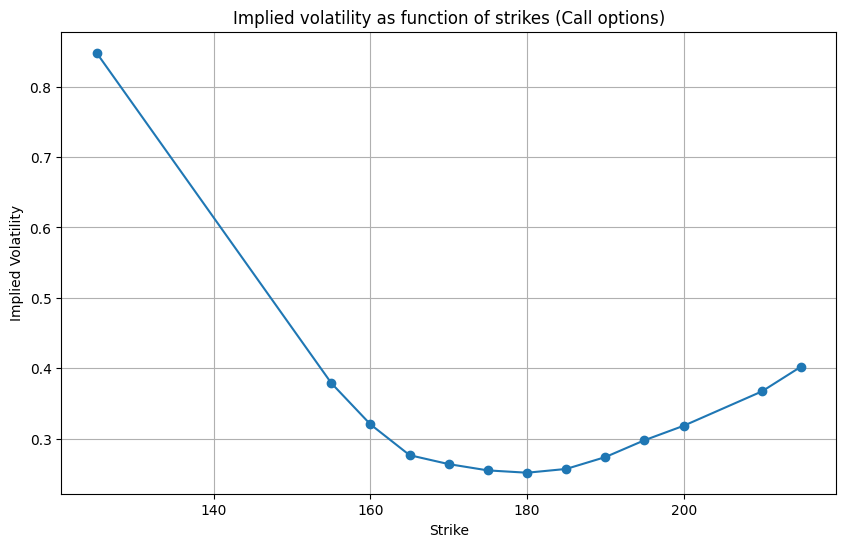

In [ ]:
strike_call = call_filter["strike"]
implied_volatility_call = call_filter["impliedVolatility"]

plt.figure(figsize=(10,6))
plt.plot(strike_call, implied_volatility_call, marker='o', linestyle='-')
plt.title("Implied volatility as function of strikes (Call options)")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.show()

# U shape
As the strike price K increases for call options, implied volatility increases. This is generally observed for OTM (Out-of-The-Money) options, as there is a lower probability of the option ending in the money, making these options riskier and more expensive.

Conversely, when the strike price falls for a call, implied volatility tends to fall. This is partly because ITM options are often more widely traded and liquid, which reduces the option premium and hence implied volatility.

### 5.2) Put Option

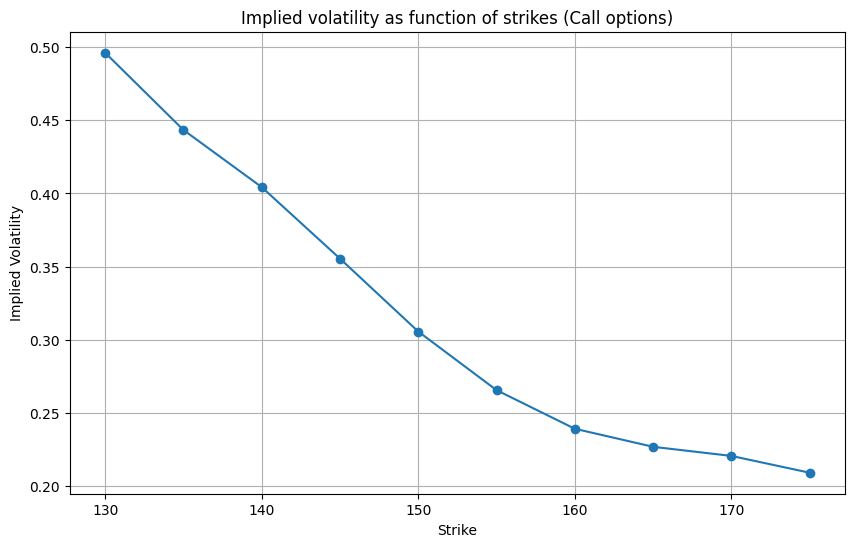

In [ ]:
strike_put = put_filter["strike"]
implied_volatility_put = put_filter["impliedVolatility"]

plt.figure(figsize=(10,6))
plt.plot(strike_put, implied_volatility_put, marker='o', linestyle='-')
plt.title("Implied volatility as function of strikes (Call options)")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.show()

## 6) Calculate implied volatility with our functions

In [ ]:
S = 100
T = df_call['daysToExpiration'] / 365  # Assurez-vous que vous avez la durée en années
r = df_call['riskFreeRate'] / 100  # Assurez-vous que vous avez le taux sans risque en pourcentage
target_price = df_call['lastPrice']  # Remplacez 'lastPrice' par le nom de la colonne contenant le prix de l'option observé sur le marché
tol = 10**-8

ImpliedVolCall(target_price, S, K, r, T, tol)

KeyError: 'daysToExpiration'